# SVM
Laden des auf IDS17 trainierten Modells  
Test auf IDS18 mit reduzierten Benign Daten

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS18

In [3]:
# IDS18 Datensatz einlesen
ids18 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids18 + '_prep_0'))
logging.info("Class distribution\n{}".format(ids18.Label.value_counts()))

2024-11-05 19:59:10 - INFO - Class distribution
Label
BENIGN                                          5935340
DoS Hulk                                        1803160
DDoS-LOIC-HTTP                                   289328
Botnet Ares                                      142921
SSH-BruteForce                                    94197
Infiltration - NMAP Portscan                      89374
DoS GoldenEye                                     22560
DoS Slowloris                                      8490
Web Attack - Brute Force                            131
Web Attack - XSS                                    113
Web Attack - SQL                                     39
DDoS-LOIC-UDP - Attempted                             0
DoS Hulk - Attempted                                  0
DoS Slowloris - Attempted                             0
DoS GoldenEye - Attempted                             0
Web Attack - XSS - Attempted                          0
Web Attack - Brute Force - Attempted              

In [4]:
print(ids18.shape)
print(ids18.columns)

(8385653, 84)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Trennen von Features und Labels

In [5]:
X = ids18.iloc[:, :-1]  # Alle Spalten außer der letzten
print(f"Form von X: {X.shape}")
y = ids18.iloc[:, -1]   # Die letzte Spalte
print(f"Form von y: {y.shape}")

Form von X: (8385653, 83)
Form von y: (8385653,)


### Label Encoding für y

In [6]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print(f"Einzigartige Labels: {label_encoder.classes_}")
print(f"Kodierte Labels: {np.unique(y_encoded)}")

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [7]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)
print(f"Form von X: {X.shape}")
print(f"Form von X_scaled: {X_scaled.shape}")

Form von X: (8385653, 83)
Form von X_scaled: (8385653, 83)


In [8]:
X_test, y_test = X_scaled, y_encoded
X_test.shape, y_test.shape

((8385653, 83), (8385653,))

### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 5935340 Beispiele (70.78%)
  Klasse 1: 142921 Beispiele (1.70%)
  Klasse 2: 289328 Beispiele (3.45%)
  Klasse 3: 22560 Beispiele (0.27%)
  Klasse 4: 1803160 Beispiele (21.50%)
  Klasse 5: 8490 Beispiele (0.10%)
  Klasse 6: 89374 Beispiele (1.07%)
  Klasse 7: 94197 Beispiele (1.12%)
  Klasse 8: 131 Beispiele (0.00%)
  Klasse 9: 39 Beispiele (0.00%)
  Klasse 10: 113 Beispiele (0.00%)



### Laden des Modells

In [11]:
model = joblib.load('svm_model.pkl')

### Evaluierung des Modells auf dem Testdatensatz

In [12]:
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
logging.info(f"Test-Accuracy: {test_accuracy * 100:.2f}%")
logging.info("\nTest Classification Report:\n" + test_report)

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-05 20:20:03

### Klassifikationsbericht und eine Konfusionsmatrix

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.72      0.98      0.83   5935340
                 Botnet Ares       1.00      0.99      1.00    142921
              DDoS-LOIC-HTTP       0.00      0.00      0.00    289328
               DoS GoldenEye       0.53      0.15      0.23     22560
                    DoS Hulk       0.00      0.00      0.00   1803160
               DoS Slowloris       0.53      0.95      0.68      8490
Infiltration - NMAP Portscan       0.49      0.66      0.56     89374
              SSH-BruteForce       0.00      0.00      0.00     94197
    Web Attack - Brute Force       0.06      0.02      0.02       131
            Web Attack - SQL       0.00      0.00      0.00        39
            Web Attack - XSS       0.76      0.97      0.85       113

                    accuracy                           0.72   8385653
                   macro avg       0.37      0.43      0.38   8385653
                we

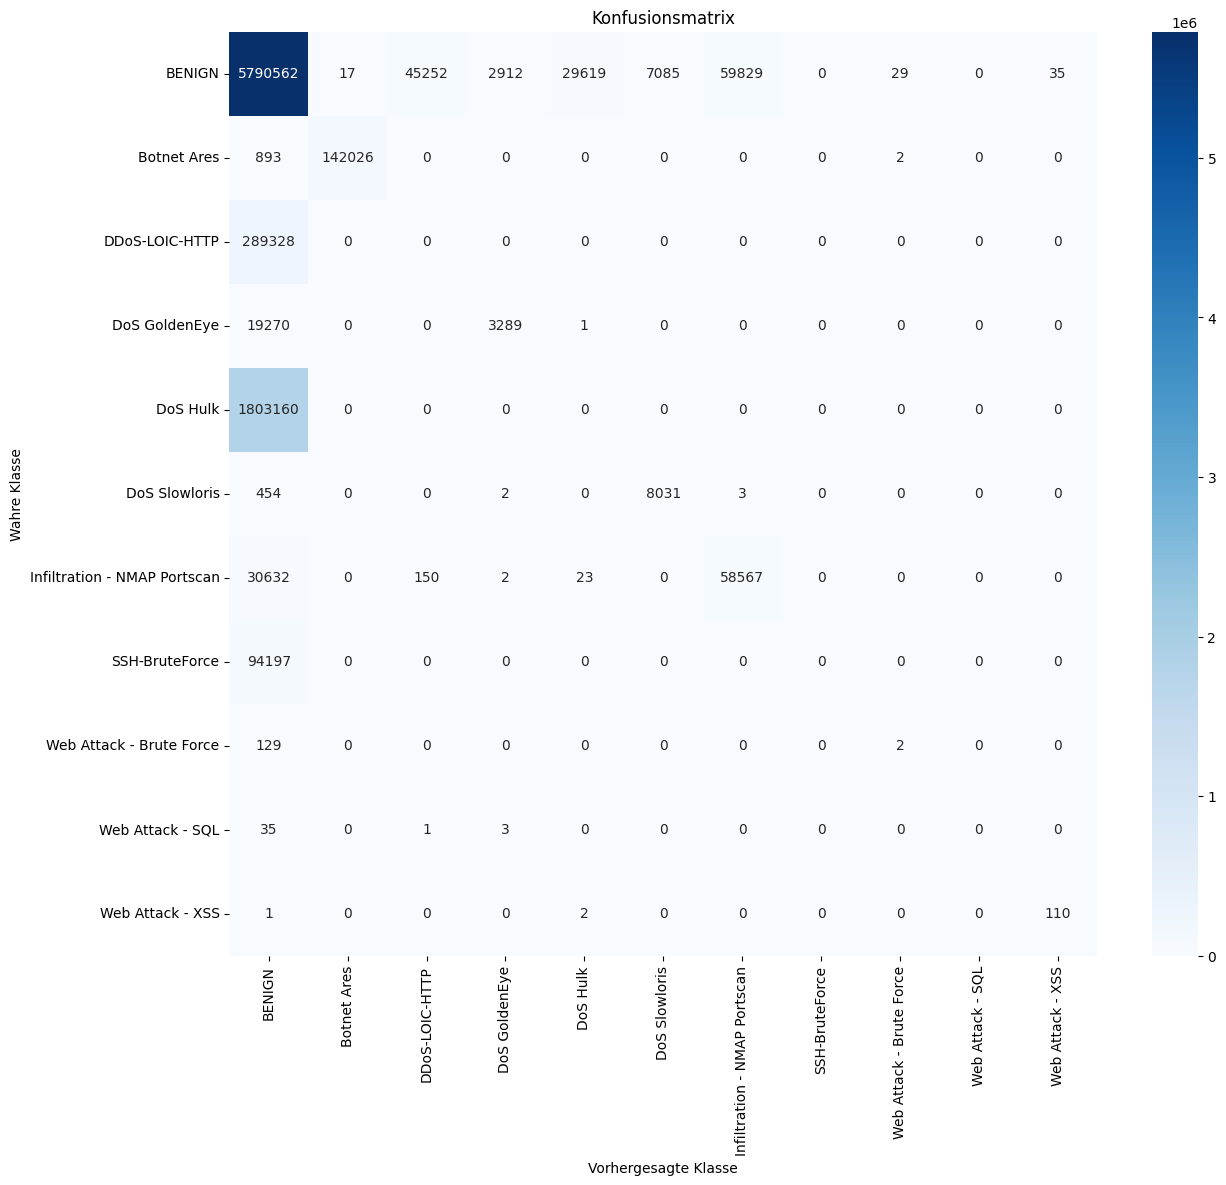

In [13]:
# Klassifikationsbericht
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
